# Join DataBases

6 Nov, 2024

@roman

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
import h3
from tqdm import tqdm
from scipy.spatial import KDTree
from scipy.stats import lognorm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 500)

---
# Load Data

## Properties

In [3]:
# read parquet
gdf_properties = pd.read_parquet("../../data/interim/cleaned_data_s6.parquet")

# to geopandas
gdf_properties = gpd.GeoDataFrame(
    gdf_properties,
    geometry=gpd.points_from_xy(gdf_properties['longitude'], gdf_properties['latitude']),
    crs="EPSG:4326"
    )

# change crs to 6372
gdf_properties = gdf_properties.to_crs("EPSG:6372")

# see
print(gdf_properties.shape)
gdf_properties.head()

(1908483, 60)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,ppsm_comps,ppsm_lower_comps,ppsm_upper_comps,num_neighbors,geometry,distance_to_ocean,ocean_label
0,1,2,4,MAYA,NO APLICA,97134,204,1,2022-11-15,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.014297,-89.575189,3,2,S/D,3,141.550003,154.929993,198.000000,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.00,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52,0,14628.264263,10389.165128,23209.085607,60.0,POINT (3784284.380 1056168.461),50000.0,golfo_de_mexico
1,0,1,3,MULCHECHEN,NO APLICA,97370,192,1,2022-11-01,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,20.916897,-89.580945,3,1,S/D,2,52.049999,54.209999,133.750000,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.00,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54,0,10173.151915,9156.730439,11403.414006,60.0,POINT (3784619.353 1045421.310),50000.0,golfo_de_mexico
2,1,4,5,LOCALIDAD DE CHABLEKAL,NO APLICA,97302,120,2,2022-11-07,NaN,NaN,NaN,NaN,5,5,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,1,NaN,1,2,050,8765c4c5-2144-413d-bc01-616fdef51316,3,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.097061,-89.618003,3,2,S/D,3,520.500000,674.960022,1200.000000,1.0,NaN,<NA>,17284861.0,17285000.0,8624980.00,5552400.00,<NA>,70,185761da-dc39-4835-86c5-981424f72208,ea19d861-f75b-5ca2-9bd6-177a0c0bd830,0,25737.697821,18219.727072,41082.528033,56.0,POINT (3779083.399 1064873.781),50000.0,golfo_de_mexico
3,1,2,3,FRACCIONAMIENTO AMANECERES,NO PROPORCIONADO,97370,0,1,2022-11-16,NaN,NaN,NaN,NaN,3,6,8b6705bf-3b28-4a0c-8e1e-564dc7d09cf3,0.0,31,1,NaN,1,3,041,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,4,NaN,NaN,NaN,2,NaN,7ffc29d8-5fe3-4c98-8570-5e5027bdd604,82a61e5f-2755-4cd2-9c60-96d1859009dd,20.961569,-89.529486,3,1,S/D,2,111.629997,111.629997,181.699997,1.0,NaN,<NA>,1183300.0,1183000.0,837225.00,199870.00,<NA>,60,4e2c4e1a-e759-48ab-a4f6-2d1dbc6f55da,d71ff72e-16ad-5c47-be4b-7c6faf2e9225,0,11062.325787,9922.074419,12451.729776,60.0,POINT (3789501.256 1050788.609),50000.0,golfo_de_mexico
4,0,2,4,MERIDA,NO APLICA,97206,240,1,2022-11-23,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.015836,-89.654367,3,1,S/D,3,103.570000,138.380005,364.000000,1.0,NaN,<NA>,1878072.0,1878000.0,762310.40,948518.48,<NA>,50,d51a3c97-180f-453a-8364-800116e0bfd6,5b145754-3253-589b-8de7-cab1f74fdde3,0,10613.599657,7070.157571,19137.024596,60.0,POINT (3776105.913 1055630.688),50000.0,golfo_de_mexico


In [4]:
# paste accesory area
# read parquet
df_temp_properties = pd.read_parquet("../../data/raw/appraisals.parquet").loc[:, ["observation_id", "accessory_area"]]

# join
gdf_properties = gdf_properties.merge(
    df_temp_properties,
    how="inner",
    on="observation_id"
    )

# check
print(gdf_properties.shape)
gdf_properties.head()

(1908483, 61)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,ppsm_comps,ppsm_lower_comps,ppsm_upper_comps,num_neighbors,geometry,distance_to_ocean,ocean_label,accessory_area
0,1,2,4,MAYA,NO APLICA,97134,204,1,2022-11-15,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.014297,-89.575189,3,2,S/D,3,141.550003,154.929993,198.000000,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.00,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52,0,14628.264263,10389.165128,23209.085607,60.0,POINT (3784284.380 1056168.461),50000.0,golfo_de_mexico,13.380000
1,0,1,3,MULCHECHEN,NO APLICA,97370,192,1,2022-11-01,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,20.916897,-89.580945,3,1,S/D,2,52.049999,54.209999,133.750000,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.00,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54,0,10173.151915,9156.730439,11403.414006,60.0,POINT (3784619.353 1045421.310),50000.0,golfo_de_mexico,2.160000
2,1,4,5,LOCALIDAD DE CHABLEKAL,NO APLICA,97302,120,2,2022-11-07,NaN,NaN,NaN,NaN,5,5,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,1,NaN,1,2,050,8765c4c5-2144-413d-bc01-616fdef51316,3,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.097061,-89.618003,3,2,S/D,3,520.500000,674.960022,1200.000000,1.0,NaN,<NA>,17284861.0,17285000.0,8624980.00,5552400.00,<NA>,70,185761da-dc39-4835-86c5-981424f72208,ea19d861-f75b-5ca2-9bd6-177a0c0bd830,0,25737.697821,18219.727072,41082.528033,56.0,POINT (3779083.399 1064873.781),50000.0,golfo_de_mexico,154.460007
3,1,2,3,FRACCIONAMIENTO AMANECERES,NO PROPORCIONADO,97370,0,1,2022-11-16,NaN,NaN,NaN,NaN,3,6,8b6705bf-3b28-4a0c-8e1e-564dc7d09cf3,0.0,31,1,NaN,1,3,041,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,4,NaN,NaN,NaN,2,NaN,7ffc29d8-5fe3-4c98-8570-5e5027bdd604,82a61e5f-2755-4cd2-9c60-96d1859009dd,20.961569,-89.529486,3,1,S/D,2,111.629997,111.629997,181.699997,1.0,NaN,<NA>,1183300.0,1183000.0,837225.00,199870.00,<NA>,60,4e2c4e1a-e759-48ab-a4f6-2d1dbc6f55da,d71ff72e-16ad-5c47-be4b-7c6faf2e9225,0,11062.325787,9922.074419,12451.729776,60.0,POINT (3789501.256 1050788.609),50000.0,golfo_de_mexico,0.000000
4,0,2,4,MERIDA,NO APLICA,97206,240,1,2022-11-23,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,b6ec5872-8e1c-4a3e-908f-5dc1ab822e5b,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.015836,-89.654367,3,1,S/D,3,103.570000,138.380005,364.000000,1.0,NaN,<NA>,1878072.0,1878000.0,762310.40,948518.48,<NA>,50,d51a3c97-180f-453a-8364-800116e0bfd6,5b145754-3253-589b-8de7-cab1f74fdde3,0,10613.599657,7070.157571,19137.024596,60.0,POINT (3776105.913 1055630.688),50000.0,golfo_de_mexico,34.810001


In [5]:
# delete df_temp_properties
del df_temp_properties

## ENIGH

### Concentrado Hogar

In [6]:
# cols 2 stay
columns_to_stay_hogar_enigh = [
    "ubica_geo", "year",
    "tam_loc", "est_socio", 
    "clase_hog", "sexo_jefe", "edad_jefe", "educa_jefe", "tot_integ", "mayores",
    "menores", "p12_64", "p65mas", "percep_ing", "ing_cor", "estim_alqu", 
    "otros_ing", "gasto_mon", "vivienda", "alquiler", "pred_cons", "cuidados",
]

# read enigh
df_concentrado_hogar_enigh = pd.read_csv("../../data/interim/concentrado_hogar_enigh.csv")
df_concentrado_hogar_enigh = df_concentrado_hogar_enigh[columns_to_stay_hogar_enigh]

# see
print(df_concentrado_hogar_enigh.shape)
df_concentrado_hogar_enigh.head()


(1038, 22)


,ubica_geo,year,tam_loc,est_socio,clase_hog,sexo_jefe,edad_jefe,educa_jefe,tot_integ,mayores,menores,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados
0,1001,2018,1.313242,2.830593,2.0,1.0,50.089514,6.479373,3.721097,2.999458,0.721640,2.691494,0.307964,2.391824,63956.301534,6351.823899,46.323383,39119.615453,3114.482487,1146.301370,175.330648,1727.998294
1,1001,2020,1.191967,2.848673,2.0,1.0,50.307018,6.518359,3.511532,2.877479,0.634053,2.578268,0.299212,2.295080,60912.502414,6937.108693,78.762806,37361.636895,3523.484832,1395.231161,184.045724,1552.910254
2,1001,2022,1.260126,2.843422,2.0,1.0,50.853007,6.667584,3.485117,2.844748,0.640369,2.536844,0.307904,2.319125,85273.975500,8849.450081,115.145540,47870.292160,4335.689380,1732.631168,335.986748,2252.075444
3,1005,2018,3.006706,2.289274,2.0,1.0,45.461916,6.186617,4.025102,3.090068,0.935034,2.915252,0.174815,2.538047,62425.257471,4832.711173,13.453221,40447.472278,2864.566049,902.798797,209.100271,1647.925020
4,1005,2020,2.915232,2.345722,2.0,1.0,47.396102,5.892137,3.988493,3.215378,0.773114,3.048939,0.166440,2.517314,58610.447087,5442.595426,136.200860,35552.268076,3085.935918,1084.445514,199.979916,1682.611930


### Viviendas

In [7]:
# important cols
columns_to_stay_vivienda_enigh = [
    "ubica_geo", "year",
    "tipo_viv", "antiguedad", "cuart_dorm", "tenencia", "renta",
    "estim_pago", "pago_viv", "pago_mesp", "tipo_adqui", "viv_usada", "tipo_finan",
    "escrituras", "tot_resid", "tot_hom", "tot_muj", "tot_hog", "total_viviendas"
]

# read viviendas
df_viviendas_enigh = pd.read_csv("../../data/interim/viviendas_enigh.csv")
df_viviendas_enigh = df_viviendas_enigh[columns_to_stay_vivienda_enigh]

# see
print(df_viviendas_enigh.shape)
df_viviendas_enigh.head()

(1038, 19)


,ubica_geo,year,tipo_viv,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,escrituras,tot_resid,tot_hom,tot_muj,tot_hog,total_viviendas
0,1001,2018,1.0,19.145343,2.460400,4.0,385.384175,2165.050435,442.032669,0.362238,1.0,0.166781,1.0,1.0,3.781875,1.806226,1.975650,1.019717,234164.0
1,1001,2020,1.0,18.578944,2.355871,4.0,484.117574,2361.336658,670.729401,0.385572,1.0,0.161022,1.0,1.0,3.555936,1.693341,1.862595,1.016633,267473.0
2,1001,2022,1.0,20.415628,2.393433,4.0,594.349359,3013.785845,711.650391,0.386612,1.0,0.179857,1.0,1.0,3.514820,1.645770,1.869050,1.010339,267713.0
3,1005,2018,1.0,17.957064,2.421640,4.0,316.383800,1650.605073,640.096362,0.365966,1.0,0.103256,5.0,1.0,4.099135,2.150613,1.948522,1.024653,26691.0
4,1005,2020,1.0,16.014364,2.221359,4.0,360.672807,1863.259378,362.239594,0.303057,1.0,0.123321,5.0,1.0,4.024456,1.997624,2.026832,1.010092,37455.0


### Merge

In [8]:
# enigh data
df_enigh = pd.merge(
    df_concentrado_hogar_enigh,
    df_viviendas_enigh,
    on=["ubica_geo", "year"],
    how="inner"
)

# zfill 5 to ubica_geo
df_enigh["ubica_geo"] = df_enigh["ubica_geo"].astype(str).str.zfill(5)

# see
print(df_enigh.shape)
df_enigh.head()

(1038, 39)


,ubica_geo,year,tam_loc,est_socio,clase_hog,sexo_jefe,edad_jefe,educa_jefe,tot_integ,mayores,menores,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,tipo_viv,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,escrituras,tot_resid,tot_hom,tot_muj,tot_hog,total_viviendas
0,01001,2018,1.313242,2.830593,2.0,1.0,50.089514,6.479373,3.721097,2.999458,0.721640,2.691494,0.307964,2.391824,63956.301534,6351.823899,46.323383,39119.615453,3114.482487,1146.301370,175.330648,1727.998294,1.0,19.145343,2.460400,4.0,385.384175,2165.050435,442.032669,0.362238,1.0,0.166781,1.0,1.0,3.781875,1.806226,1.975650,1.019717,234164.0
1,01001,2020,1.191967,2.848673,2.0,1.0,50.307018,6.518359,3.511532,2.877479,0.634053,2.578268,0.299212,2.295080,60912.502414,6937.108693,78.762806,37361.636895,3523.484832,1395.231161,184.045724,1552.910254,1.0,18.578944,2.355871,4.0,484.117574,2361.336658,670.729401,0.385572,1.0,0.161022,1.0,1.0,3.555936,1.693341,1.862595,1.016633,267473.0
2,01001,2022,1.260126,2.843422,2.0,1.0,50.853007,6.667584,3.485117,2.844748,0.640369,2.536844,0.307904,2.319125,85273.975500,8849.450081,115.145540,47870.292160,4335.689380,1732.631168,335.986748,2252.075444,1.0,20.415628,2.393433,4.0,594.349359,3013.785845,711.650391,0.386612,1.0,0.179857,1.0,1.0,3.514820,1.645770,1.869050,1.010339,267713.0
3,01005,2018,3.006706,2.289274,2.0,1.0,45.461916,6.186617,4.025102,3.090068,0.935034,2.915252,0.174815,2.538047,62425.257471,4832.711173,13.453221,40447.472278,2864.566049,902.798797,209.100271,1647.925020,1.0,17.957064,2.421640,4.0,316.383800,1650.605073,640.096362,0.365966,1.0,0.103256,5.0,1.0,4.099135,2.150613,1.948522,1.024653,26691.0
4,01005,2020,2.915232,2.345722,2.0,1.0,47.396102,5.892137,3.988493,3.215378,0.773114,3.048939,0.166440,2.517314,58610.447087,5442.595426,136.200860,35552.268076,3085.935918,1084.445514,199.979916,1682.611930,1.0,16.014364,2.221359,4.0,360.672807,1863.259378,362.239594,0.303057,1.0,0.123321,5.0,1.0,4.024456,1.997624,2.026832,1.010092,37455.0


In [9]:
# see lengths of ubica_geo
df_enigh["ubica_geo"].str.len().value_counts()

ubica_geo
5    1038
Name: count, dtype: int64

^^^
note: see if all properties have a match in enigh

## Banxico

### INPC

In [10]:
# date
min_year = gdf_properties["valuation_date"].min()

# important cols
columns_to_stay_inpc = [
    "date", "inpc", "em_avg_pct_change_inpc"
]

# read indexes
df_inpc = pd.read_csv("../../data/interim/inpc.csv")
df_inpc = df_inpc[columns_to_stay_inpc]

# see
print(df_inpc.shape)
df_inpc.head()

(103, 3)


,date,inpc,em_avg_pct_change_inpc
0,2016-01-01,89.386381,NaN
1,2016-02-01,89.777781,0.004379
2,2016-03-01,89.910001,0.003548
3,2016-04-01,89.625278,0.001630
4,2016-05-01,89.225615,-0.000110


In [11]:
# wrangle
df_inpc = (
    df_inpc
    .assign(
        lag_year_inpc=lambda x: x['inpc'].shift(12),
        lag_3months_em_avg_pct_change_inpc=lambda x: x['em_avg_pct_change_inpc'].shift(3),
        date=lambda x: pd.to_datetime(x['date'])
    )
    .query("date.dt.year >= @min_year.year")
    .reset_index(drop=True)
    .drop(columns=["inpc", "em_avg_pct_change_inpc"])
)

# see
print(df_inpc.shape)
df_inpc.head()

(67, 3)


,date,lag_year_inpc,lag_3months_em_avg_pct_change_inpc
0,2019-01-01,98.795000,0.004269
1,2019-02-01,99.171374,0.005480
2,2019-03-01,99.492157,0.005917
3,2019-04-01,99.154847,0.004470
4,2019-05-01,98.994080,0.003113


### Minimum Wage

In [12]:
# important cols
columns_to_stay_wage = [
    "date", "general_minimum_wage", "em_avg_general"
]

# read indexes
df_wage = pd.read_csv("../../data/interim/minimum_wage.csv")
df_wage = df_wage[columns_to_stay_wage]

# see
print(df_wage.shape)
df_wage.head()

(93, 3)


,date,general_minimum_wage,em_avg_general
0,2017-01-01,99.6963,NaN
1,2017-02-01,99.1235,NaN
2,2017-03-01,98.5190,NaN
3,2017-04-01,98.3980,NaN
4,2017-05-01,98.5158,NaN


In [13]:
# wrangle
df_wage = (
    df_wage
    .assign(
        lag_year_general_minimum_wage=lambda x: x['general_minimum_wage'].shift(12),
        lag_3months_em_avg_general=lambda x: x['em_avg_general'].shift(3),
        date=lambda x: pd.to_datetime(x['date'])
    )
    .query("date.dt.year >= @min_year.year")
    .reset_index(drop=True)
    .drop(columns=["general_minimum_wage", "em_avg_general"])
)

# see
print(df_wage.shape)
df_wage.head()

(69, 3)


,date,lag_year_general_minimum_wage,lag_3months_em_avg_general
0,2019-01-01,104.2765,0.052312
1,2019-02-01,103.8808,0.052859
2,2019-03-01,103.5459,0.024591
3,2019-04-01,103.8981,0.049981
4,2019-05-01,104.0668,0.069418


### Merge

In [14]:
# merge
df_banxico = (
    pd.merge(
        df_inpc,
        df_wage,
        on="date",
        how="inner"
    ).rename(columns={
            "lag_3months_em_avg_general": "lag_3months_em_avg_general_wage",
    })
)

# see
print(df_banxico.shape)
df_banxico.head()

(67, 5)


,date,lag_year_inpc,lag_3months_em_avg_pct_change_inpc,lag_year_general_minimum_wage,lag_3months_em_avg_general_wage
0,2019-01-01,98.795000,0.004269,104.2765,0.052312
1,2019-02-01,99.171374,0.005480,103.8808,0.052859
2,2019-03-01,99.492157,0.005917,103.5459,0.024591
3,2019-04-01,99.154847,0.004470,103.8981,0.049981
4,2019-05-01,98.994080,0.003113,104.0668,0.069418


## DENUE

In [15]:
# important columns
columns_to_stay_denue = [
    'Fecha_Alta', 'category', 'geometry'
]

# get denue data
gdf_denue = gpd.read_parquet("../../data/misc/denue_data.parquet")
gdf_denue = gdf_denue[columns_to_stay_denue]


# geometry to crs
gdf_denue = gdf_denue.to_crs("EPSG:6372")

# see
print(gdf_denue.shape)
gdf_denue.head()

(14225, 3)


,Fecha_Alta,category,geometry
0,2010-07-01,supermarkets,POINT (2566629.977 964916.350)
1,2010-07-01,supermarkets,POINT (2791472.433 841445.827)
2,2010-07-01,supermarkets,POINT (2785414.263 825108.458)
3,2010-07-01,supermarkets,POINT (2795636.961 813163.543)
4,2010-07-01,supermarkets,POINT (2494203.156 822602.670)


In [16]:
# counts
gdf_denue["category"].value_counts()

category
restaurants     8192
supermarkets    4647
hospitals        670
schools          499
metro            217
Name: count, dtype: int64

<Axes: >

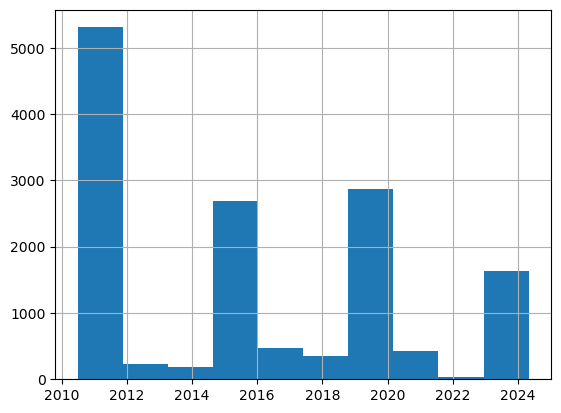

In [17]:
# see distribution of fecha_alta
gdf_denue["Fecha_Alta"].hist()

## Terrains

In [18]:
# read parquet
df_terrain_prices = pd.read_parquet("../../data/misc/terrain_prices.parquet")
df_terrain_prices.isnull().sum()


hex_id                              0
mean_log_valor_fisico_terreno_m2    0
std_log_valor_fisico_terreno_m2     0
city_cluster                        0
dtype: int64

In [19]:
df_terrain_prices.drop(['hex_id', 'city_cluster'], axis=1).eq(0).sum()

mean_log_valor_fisico_terreno_m2       0
std_log_valor_fisico_terreno_m2     6551
dtype: int64

In [20]:
# wrangle
df_terrain_prices = (
    df_terrain_prices
    .assign(
        ppsm_terrain=lambda x: np.exp(x["mean_log_valor_fisico_terreno_m2"] + x["std_log_valor_fisico_terreno_m2"]**2/2),
        ppsm_terrain_lower=lambda x: lognorm.ppf(0.05, s=x["std_log_valor_fisico_terreno_m2"], scale=np.exp(x["mean_log_valor_fisico_terreno_m2"])),
        ppsm_terrain_upper=lambda x: lognorm.ppf(0.95, s=x["std_log_valor_fisico_terreno_m2"], scale=np.exp(x["mean_log_valor_fisico_terreno_m2"]))
    )
    .assign(
        # fill nan with mean
        ppsm_terrain_lower=lambda x: np.where(
            x["ppsm_terrain_lower"].isna(),
            x["ppsm_terrain"],
            x["ppsm_terrain_lower"]
        ),
        ppsm_terrain_upper=lambda x: np.where(
            x["ppsm_terrain_upper"].isna(),
            x["ppsm_terrain"],
            x["ppsm_terrain_upper"]
        ),

    )
    .drop(columns=["std_log_valor_fisico_terreno_m2", "city_cluster", "mean_log_valor_fisico_terreno_m2"])
)

# get longitude and latitude of the center of the hexagon
df_terrain_prices["hex_longitude"], df_terrain_prices["hex_latitude"] = zip(
    *df_terrain_prices["hex_id"].apply(h3.h3_to_geo)
    )

# see
print(df_terrain_prices.shape)
df_terrain_prices.head()

(261712, 6)


,hex_id,ppsm_terrain,ppsm_terrain_lower,ppsm_terrain_upper,hex_longitude,hex_latitude
0,89450984803ffff,804.197946,398.148805,1402.891591,20.920002,-89.554488
1,89450984807ffff,810.179333,409.471139,1395.177073,20.922102,-89.557015
2,8945098480bffff,770.392220,407.957293,1287.634180,20.921128,-89.551302
3,8945098480fffff,803.498238,399.389908,1398.196428,20.923228,-89.553829
4,89450984813ffff,808.799557,404.388395,1402.273919,20.916777,-89.555146


## Embeddings

In [21]:
# read parquet
gdf_hex_embeddings = pd.read_parquet("../../data/misc/hex_embeddings_d16_v2.parquet")

# columns with hex_embeddings add sufix d16
gdf_hex_embeddings = gdf_hex_embeddings.rename(
    columns=lambda x: x + "_d16_v2" if x not in ["hex_id"] else x
)

# look
print(gdf_hex_embeddings.shape)
gdf_hex_embeddings.head()

(261712, 17)


,hex_id,hex_embedding_1_d16_v2,hex_embedding_2_d16_v2,hex_embedding_3_d16_v2,hex_embedding_4_d16_v2,hex_embedding_5_d16_v2,hex_embedding_6_d16_v2,hex_embedding_7_d16_v2,hex_embedding_8_d16_v2,hex_embedding_9_d16_v2,hex_embedding_10_d16_v2,hex_embedding_11_d16_v2,hex_embedding_12_d16_v2,hex_embedding_13_d16_v2,hex_embedding_14_d16_v2,hex_embedding_15_d16_v2,hex_embedding_16_d16_v2
0,89450984803ffff,1.226548,-2.105018,0.980468,0.004962,1.388463,-3.114058,0.175245,-0.141921,-1.121091,-1.674633,0.176828,0.982042,-2.988769,-0.198455,-2.142136,-1.020302
1,89450984807ffff,1.244653,-2.061231,0.867655,-0.035147,1.327668,-3.105197,0.259648,-0.149245,-1.162221,-1.612379,0.207615,0.977444,-3.007813,-0.191676,-2.067218,-1.100550
2,8945098480bffff,1.298778,-2.005947,1.099923,-0.111693,1.201540,-3.093980,0.316485,-0.050870,-1.329637,-1.730504,0.155120,1.143537,-3.026915,-0.121923,-2.051444,-1.063948
3,8945098480fffff,1.197906,-1.991767,0.976100,-0.100657,1.437752,-3.219944,0.211685,-0.054004,-1.168892,-1.820608,0.153301,0.834648,-2.919081,-0.141560,-1.947374,-1.189573
4,89450984813ffff,1.243597,-1.919230,1.025213,0.056413,1.146621,-3.069181,0.277293,-0.204666,-1.146666,-1.496874,0.192501,1.269446,-3.082055,-0.237326,-2.271990,-0.919029


---
# Mega Merge

## Merge

In [22]:
def latlon_to_h3(latitudes, longitudes, resolution):
    """
    Convert latitude and longitude arrays to H3 hexagon IDs at a given resolution.
    
    Parameters:
    - latitudes: numpy array of latitudes
    - longitudes: numpy array of longitudes
    - resolution: H3 resolution
    
    Returns:
    - numpy array of H3 hexagon IDs
    """
    # Ensure inputs are numpy arrays
    latitudes = np.asarray(latitudes)
    longitudes = np.asarray(longitudes)
    
    # Check that latitudes and longitudes are the same shape
    if latitudes.shape != longitudes.shape:
        raise ValueError("Latitudes and longitudes must be the same shape")
    
    # Vectorize the h3 function
    vectorized_h3 = np.vectorize(h3.geo_to_h3)
    
    # Apply the function to the latitude and longitude arrays
    hex_ids = vectorized_h3(latitudes, longitudes, resolution)
    
    return hex_ids

# Get hex id for each property
HEX_RESOLUTION = 9
gdf_properties['hex_id'] = latlon_to_h3(
    gdf_properties['latitude'].values,
    gdf_properties['longitude'].values,
    HEX_RESOLUTION
)

In [23]:
# define function to get poiunts at r distance
def count_denues(gdf_props, gdf_denues, r=1):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf_denues[['longitude', 'latitude']],
    )

    # count neighbors at r-km
    return kdtree.query_ball_point(
        gdf_props[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )

# set crs to 6372
gdf_properties = gdf_properties.to_crs('EPSG:6372')
gdf_denue = gdf_denue.to_crs('EPSG:6372')

# get longitude & latitude
gdf_properties['longitude'] = gdf_properties.centroid.x
gdf_properties['latitude'] = gdf_properties.centroid.y

gdf_denue['longitude'] = gdf_denue.centroid.x
gdf_denue['latitude'] = gdf_denue.centroid.y

years_to_consider = gdf_properties['valuation_date'].dt.year.unique()

# count denues
dict_activities_search = {
    'supermarkets': 1,  # 1 km
    'hospitals': 5,
    'metro': 1,
    'schools': 1,
    'restaurants': 1
}

In [24]:
# create columns
for category, radius in dict_activities_search.items():
    gdf_properties[f'count_{category}_at_{radius}km'] = np.nan

# count
for year in tqdm(years_to_consider):
    for category, radius in dict_activities_search.items():
        # mask for properties and denues
        mask_properties = gdf_properties['valuation_date'].dt.year.eq(year)
        mask_denue = gdf_denue['Fecha_Alta'].dt.year.le(year) & gdf_denue['category'].eq(category)
        # count
        gdf_properties.loc[mask_properties, f'count_{category}_at_{radius}km'] = count_denues(
            gdf_properties.loc[mask_properties],
            gdf_denue[mask_denue],
            r=radius
        )

# drop columns
gdf_properties = gdf_properties.drop(columns=['longitude', 'latitude'])

# see new cols
gdf_properties.iloc[:, -5:].head()

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km
0,2.0,3.0,0.0,0.0,19.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0


In [25]:
# see num of ceros
gdf_properties.iloc[:, -5:].eq(0).mean()

count_supermarkets_at_1km    0.572600
count_hospitals_at_5km       0.457909
count_metro_at_1km           0.979302
count_schools_at_1km         0.949045
count_restaurants_at_1km     0.803791
dtype: float64

array([[<Axes: title={'center': 'count_supermarkets_at_1km'}>,
        <Axes: title={'center': 'count_hospitals_at_5km'}>],
       [<Axes: title={'center': 'count_metro_at_1km'}>,
        <Axes: title={'center': 'count_schools_at_1km'}>],
       [<Axes: title={'center': 'count_restaurants_at_1km'}>, <Axes: >]],
      dtype=object)

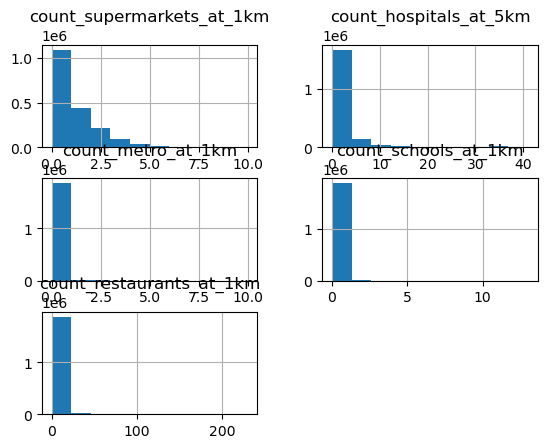

In [26]:
# see distribution of count
gdf_properties.iloc[:, -5:].hist()

In [27]:
# merge all
gdf_properties = (
    gdf_properties
    # merge with enigh
    .assign(
        ubica_geo=lambda x: x["state_id"] + x["municipality_id"],
        year=lambda x: x["valuation_date"].dt.year // 2 * 2 , # every 2 years
    )
    .merge(
        df_enigh,
        on=["ubica_geo", "year"],
        how="inner"
    )
    .drop(columns=["ubica_geo", "year"])
    # merge with banxico
    .assign(
        # get start of month of valuation_date
        date=lambda x: x["valuation_date"].dt.to_period("M").dt.to_timestamp(),
    )
    .merge(
        df_banxico,
        on=["date"],
        how="inner"
    )
    .drop(columns=["date"])
    # terrains
    .merge(
        df_terrain_prices,
        on="hex_id",
        how="inner"
    )
    # merge with hex embeddings
    .merge(
        gdf_hex_embeddings,
        on="hex_id",
        how="inner"
    )
)

# print shape
print(gdf_properties.shape)
print(gdf_properties["observation_id"].duplicated().sum())

gdf_properties.head()

(1908483, 127)
0


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,ppsm_comps,ppsm_lower_comps,ppsm_upper_comps,num_neighbors,geometry,distance_to_ocean,ocean_label,accessory_area,hex_id,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,tam_loc,est_socio,clase_hog,sexo_jefe,edad_jefe,educa_jefe,tot_integ,mayores,menores,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,tipo_viv,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,escrituras,tot_resid,tot_hom,tot_muj,tot_hog,total_viviendas,lag_year_inpc,lag_3months_em_avg_pct_change_inpc,lag_year_general_minimum_wage,lag_3months_em_avg_general_wage,ppsm_terrain,ppsm_terrain_lower,ppsm_terrain_upper,hex_longitude,hex_latitude,hex_embedding_1_d16_v2,hex_embedding_2_d16_v2,hex_embedding_3_d16_v2,hex_embedding_4_d16_v2,hex_embedding_5_d16_v2,hex_embedding_6_d16_v2,hex_embedding_7_d16_v2,hex_embedding_8_d16_v2,hex_embedding_9_d16_v2,hex_embedding_10_d16_v2,hex_embedding_11_d16_v2,hex_embedding_12_d16_v2,hex_embedding_13_d16_v2,hex_embedding_14_d16_v2,hex_embedding_15_d16_v2,hex_embedding_16_d16_v2
0,1,2,4,MAYA,NO APLICA,97134,204,1,2022-11-15,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,3,2,S/D,3,141.550003,154.929993,198.000000,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.00,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52,0,14628.264263,10389.165128,23209.085607,60.0,POINT (3784284.380 1056168.461),50000.0,golfo_de_mexico,13.380000,894509bad13ffff,2.0,3.0,0.0,0.0,19.0,1.211412,2.725384,2.0,1.0,52.330145,7.062221,3.196693,2.740645,0.456048,2.367257,0.373388,2.210988,81674.454267,10253.206223,31.565142,47140.270007,3390.347225,1129.408686,295.455021,2439.210638,1.0,24.320178,2.015692,4.0,389.655102,3491.472513,512.81345,0.279052,1.0,0.174490,1.0,1.0,3.256174,1.561464,1.694710,1.019358,294870.0,116.884,0.006744,141.3451,0.125374,3740.659556,1841.811509,6547.739886,21.013930,-89.576725,0.419130,-0.341631,-0.565258,-0.087741,1.195428,-0.050312,1.243741,-1.325090,-1.777689,-2.644951,-3.004333,0.307720,0.795016,1.133051,-2.090828,-2.386889
1,0,1,3,MULCHECHEN,NO APLICA,97370,192,1,2022-11-01,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,3,1,S/D,2,52.049999,54.209999,133.750000,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.00,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54,0,10173.151915,9156.730439,11403.414006,60.0,POINT (3784619.353 1045421.310),50000.0,golfo_de_mexico,2.160000,89450984d33ffff,0.0,0.0,0.0,0.0,0.0,2.117395,1.929346,2.0,1.0,46.321577,5.657227,4.043336,3.227810,0.815527,2.965359,0.262450,2.564061,54447.477281,4833.395948,3.735561,37908.296877,1927.791327,391.177160,157.040633,1460.746520,1.0,17.649275,1.934266,4.0,133.639406,1646.661804,567.75989,0.3

## Nan values

In [28]:
# nan values
gdf_properties.isnull().mean()[gdf_properties.isnull().sum() > 0]

neighborhood                        0.000062
constructor                         0.001318
potable_water_service_id            0.331496
lighting_service_id                 0.331485
sidewalk_id                         0.332295
project_quality_id                  0.338993
elevator_service_id                 0.048070
curb_id                             0.331485
water_collection_service_id         0.331485
electrical_supply_service_id        0.331485
telephone_service_supply_id         0.331485
public_transportation_service_id    0.331485
rentable_units                      0.138776
rentable_units_subject_property     0.338990
current_use                         0.335894
access_routes                       0.331514
ppsm_lower_comps                    0.001428
ppsm_upper_comps                    0.001428
tipo_finan                          0.000004
dtype: float64

---
# Save

In [29]:
# see cols info
gdf_properties.info(True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1908483 entries, 0 to 1908482
Data columns (total 127 columns):
 #    Column                              Dtype         
---   ------                              -----         
 0    half_bathrooms                      uint8         
 1    full_bathrooms                      uint8         
 2    property_class_more_common_in_area  string        
 3    neighborhood                        string        
 4    constructor                         string        
 5    zip_code                            uint32        
 6    age_in_months                       uint8         
 7    parking_lots                        uint8         
 8    valuation_date                      datetime64[ns]
 9    potable_water_service_id            float64       
 10   lighting_service_id                 float64       
 11   sidewalk_id                         float64       
 12   project_quality_id                  float64       
 13   property_class_id

In [30]:
# optimze memory
numeric_columns = gdf_properties.select_dtypes(include=[np.number]).columns
numeric_columns


Index(['half_bathrooms', 'full_bathrooms', 'zip_code', 'age_in_months',
       'parking_lots', 'potable_water_service_id', 'lighting_service_id',
       'sidewalk_id', 'project_quality_id', 'property_class_id',
       ...
       'hex_embedding_7_d16_v2', 'hex_embedding_8_d16_v2',
       'hex_embedding_9_d16_v2', 'hex_embedding_10_d16_v2',
       'hex_embedding_11_d16_v2', 'hex_embedding_12_d16_v2',
       'hex_embedding_13_d16_v2', 'hex_embedding_14_d16_v2',
       'hex_embedding_15_d16_v2', 'hex_embedding_16_d16_v2'],
      dtype='object', length=109)

In [31]:
# cap distance to ocean to 100_000
gdf_properties['distance_to_ocean'] = gdf_properties['distance_to_ocean'].clip(upper=100_000)

In [32]:
# all nan values to numeric nan
gdf_properties[numeric_columns] = gdf_properties[numeric_columns].fillna(0)

In [33]:
# Create a dictionary to hold the optimized dtypes
dtype_optimizations = {}

# Determine the best dtype for each column
for col in numeric_columns:
    if pd.api.types.is_float_dtype(gdf_properties[col]):
        # Check if all values are integer-like
        if gdf_properties[col].dropna().apply(float.is_integer).all():
            # If values are all positive, use the smallest unsigned integer type
            if gdf_properties[col].min() >= 0:
                if gdf_properties[col].max() <= np.iinfo(np.uint8).max:
                    dtype_optimizations[col] = 'uint8'
                elif gdf_properties[col].max() <= np.iinfo(np.uint16).max:
                    dtype_optimizations[col] = 'uint16'
                elif gdf_properties[col].max() <= np.iinfo(np.uint32).max:
                    dtype_optimizations[col] = 'uint32'
                else:
                    dtype_optimizations[col] = 'uint64'
            # If values include negative numbers, use the smallest signed integer type
            else:
                if gdf_properties[col].min() >= np.iinfo(np.int8).min and gdf_properties[col].max() <= np.iinfo(np.int8).max:
                    dtype_optimizations[col] = 'int8'
                elif gdf_properties[col].min() >= np.iinfo(np.int16).min and gdf_properties[col].max() <= np.iinfo(np.int16).max:
                    dtype_optimizations[col] = 'int16'
                elif gdf_properties[col].min() >= np.iinfo(np.int32).min and gdf_properties[col].max() <= np.iinfo(np.int32).max:
                    dtype_optimizations[col] = 'int32'
                else:
                    dtype_optimizations[col] = 'int64'
        else:
            # If column contains floats, set to float32
            dtype_optimizations[col] = 'float32'

# see
dtype_optimizations


{'potable_water_service_id': 'uint8',
 'lighting_service_id': 'uint8',
 'sidewalk_id': 'uint8',
 'project_quality_id': 'uint8',
 'elevator_service_id': 'uint8',
 'curb_id': 'uint8',
 'water_collection_service_id': 'uint8',
 'electrical_supply_service_id': 'uint8',
 'telephone_service_supply_id': 'uint8',
 'public_transportation_service_id': 'uint8',
 'built_area': 'float32',
 'saleable_area': 'float32',
 'land_area': 'float32',
 'rentable_units': 'int16',
 'rentable_units_subject_property': 'uint16',
 'market_price': 'uint32',
 'price': 'uint32',
 'built_price': 'float32',
 'land_price': 'float32',
 'ppsm_comps': 'float32',
 'ppsm_lower_comps': 'float32',
 'ppsm_upper_comps': 'float32',
 'num_neighbors': 'uint8',
 'distance_to_ocean': 'uint32',
 'accessory_area': 'float32',
 'count_supermarkets_at_1km': 'uint8',
 'count_hospitals_at_5km': 'uint8',
 'count_metro_at_1km': 'uint8',
 'count_schools_at_1km': 'uint8',
 'count_restaurants_at_1km': 'uint8',
 'tam_loc': 'float32',
 'est_socio':

In [34]:
# rentable units clip to 0 upper
gdf_properties['rentable_units'] = gdf_properties['rentable_units'].clip(lower=0)

In [35]:
# manual change
dtype_optimizations = {'potable_water_service_id': 'uint8',
 'lighting_service_id': 'uint8',
 'sidewalk_id': 'uint8',
 'project_quality_id': 'uint8',
 'elevator_service_id': 'uint8',
 'curb_id': 'uint8',
 'water_collection_service_id': 'uint8',
 'electrical_supply_service_id': 'uint8',
 'telephone_service_supply_id': 'uint8',
 'public_transportation_service_id': 'uint8',
 'built_area': 'uint32',
 'saleable_area': 'uint32',
 'land_area': 'uint32',
 'rentable_units': 'uint16',
 'rentable_units_subject_property': 'uint8',
 'market_price': 'uint32',
 'price': 'uint32',
 'built_price': 'uint32',
 'land_price': 'uint32',
 'ppsm_comps': 'uint32',
 'ppsm_lower_comps': 'uint32',
 'ppsm_upper_comps': 'uint32',
 'num_neighbors': 'uint8',
 'distance_to_ocean': 'uint32',
 'count_supermarkets_at_1km': 'uint8',
 'count_hospitals_at_5km': 'uint8',
 'count_metro_at_1km': 'uint8',
 'count_schools_at_1km': 'uint8',
 'count_restaurants_at_1km': 'uint8',
 'tam_loc': 'float16',
 'est_socio': 'float16',
 'clase_hog': 'uint8',
 'sexo_jefe': 'uint8',
 'edad_jefe': 'float16',
 'educa_jefe': 'float16',
 'tot_integ': 'float16',
 'mayores': 'float16',
 'menores': 'float16',
 'p12_64': 'float16',
 'p65mas': 'float16',
 'percep_ing': 'float16',
 'ing_cor': 'float32',
 'estim_alqu': 'float32',
 'otros_ing': 'float32',
 'gasto_mon': 'float32',
 'vivienda': 'float32',
 'alquiler': 'float32',
 'pred_cons': 'float32',
 'cuidados': 'float32',
 'tipo_viv': 'float16',
 'antiguedad': 'float16',
 'cuart_dorm': 'float16',
 'tenencia': 'uint8',
 'renta': 'float32',
 'estim_pago': 'float32',
 'pago_viv': 'float32',
 'pago_mesp': 'float32',
 'tipo_adqui': 'float32',
 'viv_usada': 'float16',
 'tipo_finan': 'uint8',
 'escrituras': 'uint8',
 'tot_resid': 'float16',
 'tot_hom': 'float16',
 'tot_muj': 'float16',
 'tot_hog': 'float16',
 'total_viviendas': 'uint32',
 'lag_year_inpc': 'float16',
 'lag_3months_em_avg_pct_change_inpc': 'float16',
 'lag_year_general_minimum_wage': 'float16',
 'lag_3months_em_avg_general_wage': 'float16',
 'ppsm_terrain': 'uint32',
 'ppsm_terrain_lower': 'uint32',
 'ppsm_terrain_upper': 'uint32'}

In [36]:
# Apply the optimized dtypes to the DataFrame
gdf_properties = gdf_properties.astype(dtype_optimizations)

# info
gdf_properties.info(True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1908483 entries, 0 to 1908482
Data columns (total 127 columns):
 #    Column                              Dtype         
---   ------                              -----         
 0    half_bathrooms                      uint8         
 1    full_bathrooms                      uint8         
 2    property_class_more_common_in_area  string        
 3    neighborhood                        string        
 4    constructor                         string        
 5    zip_code                            uint32        
 6    age_in_months                       uint8         
 7    parking_lots                        uint8         
 8    valuation_date                      datetime64[ns]
 9    potable_water_service_id            uint8         
 10   lighting_service_id                 uint8         
 11   sidewalk_id                         uint8         
 12   project_quality_id                  uint8         
 13   property_class_id

In [37]:
# # get longitude and latitude in crs 4326
gdf_properties = gdf_properties.to_crs("EPSG:4326")
gdf_properties['longitude'] = gdf_properties.centroid.x
gdf_properties['latitude'] = gdf_properties.centroid.y

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_74910/1704499041.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_properties['longitude'] = gdf_properties.centroid.x
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_74910/1704499041.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_properties['latitude'] = gdf_properties.centroid.y


In [38]:
# create folder
dir_save = "../../data/clean"
os.makedirs(dir_save, exist_ok=True)

# save
(
    gdf_properties
    .drop(columns=["geometry"])
    .to_parquet(f"{dir_save}/properties_shif.parquet")
)

---
# Sandbox

In [39]:
(
    gdf_denue
    .groupby("Fecha_Alta")
    .size()
)

Fecha_Alta
2010-07-01    5030
2011-03-01     278
2012-06-01     235
2013-07-01     192
2014-12-01    2231
2016-01-01     464
2016-10-01     293
2017-03-01     184
2017-11-01     277
2018-03-01      70
2018-11-01      39
2019-04-01     336
2019-11-01    2490
2020-04-01     107
2020-11-01     262
2021-05-01      56
2021-11-01       8
2022-05-01       3
2022-11-01      18
2023-11-01    1095
2024-05-01     545
dtype: int64

In [40]:
print(gdf_properties['rentable_units'].describe())
print(gdf_properties['rentable_units'].astype('float32').describe())

count    1.908483e+06
mean     1.103365e+01
std      5.340497e+01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.000000e+03
Name: rentable_units, dtype: float64
count    1.908483e+06
mean     1.103365e+01
std      5.281788e+01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.000000e+03
Name: rentable_units, dtype: float64


In [41]:
gdf_properties

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,age_in_months,parking_lots,valuation_date,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,level,total_levels,purpose_of_appraisal,bedrooms,built_area,saleable_area,land_area,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,city_cluster,ppsm_comps,ppsm_lower_comps,ppsm_upper_comps,num_neighbors,geometry,distance_to_ocean,ocean_label,accessory_area,hex_id,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,tam_loc,est_socio,clase_hog,sexo_jefe,edad_jefe,educa_jefe,tot_integ,mayores,menores,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,tipo_viv,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,escrituras,tot_resid,tot_hom,tot_muj,tot_hog,total_viviendas,lag_year_inpc,lag_3months_em_avg_pct_change_inpc,lag_year_general_minimum_wage,lag_3months_em_avg_general_wage,ppsm_terrain,ppsm_terrain_lower,ppsm_terrain_upper,hex_longitude,hex_latitude,hex_embedding_1_d16_v2,hex_embedding_2_d16_v2,hex_embedding_3_d16_v2,hex_embedding_4_d16_v2,hex_embedding_5_d16_v2,hex_embedding_6_d16_v2,hex_embedding_7_d16_v2,hex_embedding_8_d16_v2,hex_embedding_9_d16_v2,hex_embedding_10_d16_v2,hex_embedding_11_d16_v2,hex_embedding_12_d16_v2,hex_embedding_13_d16_v2,hex_embedding_14_d16_v2,hex_embedding_15_d16_v2,hex_embedding_16_d16_v2,longitude,latitude
0,1,2,4,MAYA,NO APLICA,97134,204,1,2022-11-15,0,0,0,0,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0,31,2,0,1,2,050,9a2781c9-b312-453c-86d1-a6e90584a083,2,0,0,0,2,0,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,3,2,S/D,3,141,154,198,1,0,<NA>,2348706,2349000,1111845,984852,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52,0,14628,10389,23209,60,POINT (-89.57519 21.01430),50000,golfo_de_mexico,13.380000,894509bad13ffff,2,3,0,0,19,1.210938,2.724609,2,1,52.34375,7.062500,3.197266,2.740234,0.456055,2.367188,0.373291,2.210938,81674.453125,10253.206055,31.565142,47140.269531,3390.347168,1129.408691,295.455017,2439.210693,1.0,24.312500,2.015625,4,389.655090,3491.472412,512.813477,0.279052,1.0,0.174438,1,1,3.255859,1.561523,1.694336,1.019531,294870,116.8750,0.006744,141.3750,0.125366,3740,1841,6547,21.013930,-89.576725,0.419130,-0.341631,-0.565258,-0.087741,1.195428,-0.050312,1.243741,-1.325090,-1.777689,-2.644951,-3.004333,0.307720,0.795016,1.133051,-2.090828,-2.386889,-89.575189,21.014297
1,0,1,3,MULCHECHEN,NO APLICA,97370,192,1,2022-11-01,0,0,0,0,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2,31,2,0,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,3,0,0,0,2,0,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,3,1,S/D,2,52,54,133,1,0,<NA>,424468,424000,290492,96835,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54,0,10173,9156,11403,60,POINT (-89.58095 20.91690),50000,golfo_de_mexico,2.160000,89450984d33ffff,0,0,0,0,0,2.117188,1.929688,2,1,46.31250,5.656250,4.042969,3.228516,0.815430,2.964844,0.262451,2.564453,54447.476562,4833.395996,3.735561,37908.296875,1927.791382,391.177155,157.040634,1460.746460,1.0,17.656250,1.934570,4,133.639404,1646.661743,567.759888,0.311107,1.0,0.101379,1,1,4.058594,2.070312,1.990234,1.002930,34959,116.8750,0.006744,141.3750,0.125366,886,507,1406,20.916323,-89.581846,1.449197,-2.564694,0.061476,0.281704,2.213309,-2.7947

In [42]:
gdf_properties.valuation_date

0         2022-11-15
1         2022-11-01
2         2022-11-07
3         2022-11-16
4         2022-11-23
             ...    
1908478   2019-09-23
1908479   2019-09-23
1908480   2021-07-28
1908481   2019-10-22
1908482   2020-01-21
Name: valuation_date, Length: 1908483, dtype: datetime64[ns]